## Data preparation and sanitization

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

from core.utils.preprocessing import df_to_xy

# Read and sanitize the data
#df = pd.read_excel("../data/t00/data.xls")

# Read and sanitize the data
df = pd.read_csv("../data/t00/data_t00.csv")
df_full = df.copy()
drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status", "timestamp", "rowid", "offer_dss", "offer", "offer_final"]
df = df[[col for col in df.columns if col not in drop_cols]]
df = df.dropna()


x, y = df_to_xy(df, fuse_risk=False, centered=False)

## Linear regression (continuous dataset)

**Accuracy / Loss - For model comparison**

In [2]:
MAX_GAIN = 100


#### Benchmark

In [3]:
from core.utils.benchmark import process_benchmarks, process_benchmark_cv, process_model


**Keras Model**

In [4]:
from core.models.deep import KerasModel, loss_tf, gain_tf

Using TensorFlow backend.


In [5]:
import os, sys


In [6]:
# #sci-kit like training
# sm = keras_model("mse") 
# history = sm.fit(xTrain, yTrain, validation_split=0.33, epochs=100, batch_size=64, verbose=0)
# loss_hist = pd.DataFrame(data={'loss': history.history['loss']})
# loss_hist.plot(figsize=(30,10))
# smPredict = sm.predict(xTest, batch_size=128)

# out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(smPredict)})
# stl = sm.evaluate(xTest, yTest, verbose=0)
# print("Results: %2.2f (%.2f) MSE, Scalar test loss: %.2f" % (smPredict.mean(), smPredict.std(), stl))
# #out_data.plot(figsize=(30,10))

**Featureless model (fixed value)**

In [7]:
from core.models import EMModel, RandomModel

**Convervative model**

In [8]:
from core.models import ConservativeModel

**Linear/Logistic regression**

In [9]:
from sklearn.linear_model import LinearRegression, LogisticRegression

**Random**

In [10]:
from core.models import RandomModel

**Random Forest**

In [11]:
from sklearn.ensemble.forest import RandomForestClassifier, RandomForestRegressor

**Clustering**

In [12]:
from core.models import ClusterModel, ClusterExtModel

In [13]:
from sklearn.neural_network import MLPClassifier

** Acceptance model **

In [14]:
from core.models import AcceptanceModel

** Data augmentation **

In [15]:
from core.utils.data_augmentation import DACombine

**Baseline models**

In [16]:
from sklearn.svm import SVC

benchmark_models = {
    #Featureless:
    "random": RandomModel(MAX_GAIN),
    "conservative": ConservativeModel(MAX_GAIN),
    "em": EMModel(MAX_GAIN),
    "svc": SVC(gamma='auto'),
    "linear_regressor": LinearRegression(copy_X=False),
#     "linear_regressor_mse": keras_linear_regression(loss="mse"),
}

results = dict()
# for key, model in benchmark_models.items():
#     results[key] = process_benchmark_cv(model, x, y.ravel())
#     results[key+"_da"] = process_benchmark_cv(model, x, y.ravel(), augment_data=2)
#results = {key: process_benchmark_cv(model, x, y.ravel()) for key, model in benchmark_models.items()}
results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None])

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
results_df = pd.DataFrame(results_mean).T
results_df.sort_values("avg_loss_ratio", inplace=True)
results_df

,avg_loss,avg_loss_ratio,avg_win_loss,invariance,loss_sum,mse,rejection_ratio
em,11.600000,0.188273,11.370175,1.000000,232.000000,369.000000,0.05
svc,11.600000,0.188273,11.370175,1.000000,232.000000,369.000000,0.05
random,36.002766,0.659966,20.030181,0.196522,720.055328,1759.801088,0.52
linear_regressor,42.490438,0.747976,31.616105,0.137534,849.808770,2374.178312,0.50
conservative,54.250000,0.916466,55.957895,1.000000,1085.000000,3252.250000,0.03


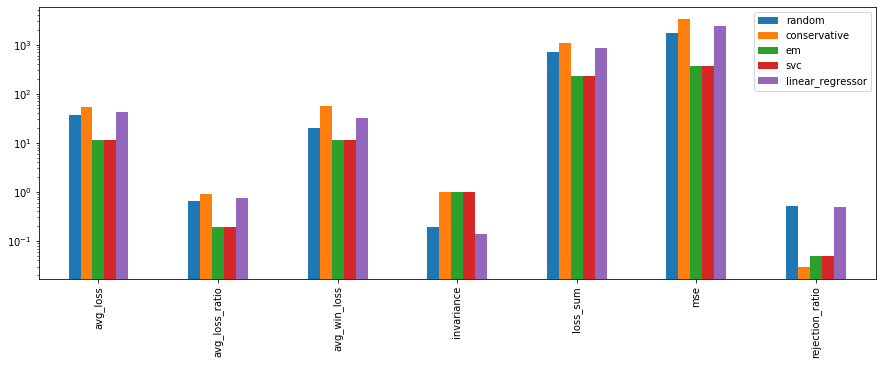

In [17]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**Clustering based models**

In [18]:
benchmark_models = {
#     #Cluster-based
    "affinity": ClusterModel(base_model="affinity"),
#     "bayes": ClusterModel(base_model="bayes", n_components=8),
#     "birch": ClusterModel(base_model="birch"),
#     "kmeans": ClusterModel(base_model="kmeans", n_clusters=16),
    "meanshift": ClusterModel(base_model="meanshift", cluster_all=True),
    "affinity_ext": ClusterExtModel(base_model="affinity"),
#     "bayes_ext": ClusterExtModel(base_model="bayes", n_components=8),
#     "birch_ext": ClusterExtModel(base_model="birch"),
#     "kmeans_ext": ClusterModel(base_model="kmeans", n_clusters=16),
    "meanshift_ext": ClusterExtModel(base_model="meanshift", cluster_all=True),
}

# results = {key: process_benchmark_cv(model, x, y.ravel(), ) for key, model in benchmark_models.items()}
results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None], shuffle=True)

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
results_df = pd.DataFrame(results_mean).T
results_df.sort_values("avg_loss_ratio", inplace=True)
results_df

,avg_loss,avg_loss_ratio,avg_win_loss,invariance,loss_sum,mse,rejection_ratio
affinity_ext,11.60,0.188273,11.325697,1.000000,232.0,369.00,0.05
meanshift_ext,11.60,0.188273,11.325697,1.000000,232.0,369.00,0.05
affinity,17.65,0.287605,17.519474,0.304254,353.0,596.49,0.05
meanshift,19.04,0.313123,19.393801,0.750074,380.8,598.76,0.04


In [19]:
pd.DataFrame(results_std).T

,avg_loss,avg_loss_ratio,avg_win_loss,invariance,loss_sum,mse,rejection_ratio
affinity,1.825171,0.040021,1.818017,0.015353,36.503424,99.312105,0.050000
meanshift,2.323360,0.029551,2.317789,0.344489,46.467193,154.843584,0.041833
affinity_ext,2.666927,0.064037,2.325130,0.000000,53.338541,112.820377,0.061237
meanshift_ext,2.666927,0.064037,2.325130,0.000000,53.338541,112.820377,0.061237


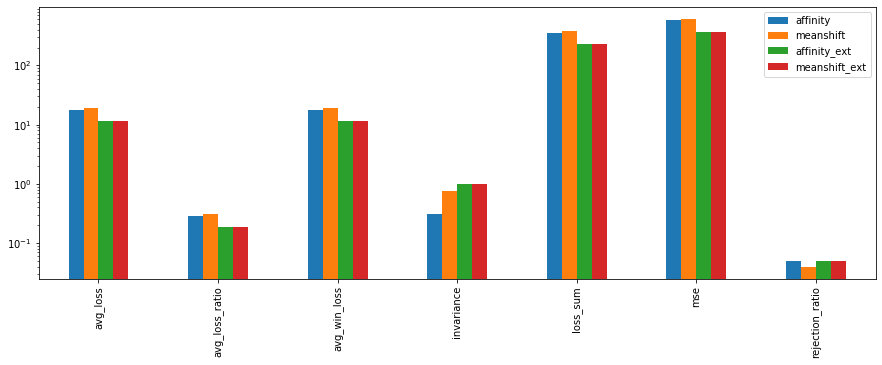

In [20]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**Other models**

In [21]:
benchmark_models = {
    'em': EMModel(),
    # Regression
    #"random_forest_regr": RandomForestRegressor(min_samples_leaf=5),
    'logistic_regression': LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'),
    #"nn_regression_hiddenless": KerasModel(no_hidden_layer=True),
#     "nn_regression": KerasModel(batch_size=30, epochs=200),
    'acceptance_model': AcceptanceModel(),   #step=10, zero_one=True),
    # Classification
    "random_forest": RandomForestClassifier(min_samples_leaf=5),#max_depth=3, random_state=0, n_estimators=10),
}

results = dict()

results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None, 2])

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
results_df = pd.DataFrame(results_mean).T
results_df.sort_values("avg_loss_ratio", inplace=True)
results_df

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

,avg_loss,avg_loss_ratio,avg_win_loss,invariance,loss_sum,mse,rejection_ratio
em,11.60,0.188273,11.370175,1.000000,232.0,369.00,0.05
random_forest,15.30,0.265664,11.512418,0.467333,306.0,569.00,0.14
em_da2,24.35,0.454524,13.301515,1.000000,487.0,1044.75,0.35
logistic_regression,33.05,0.583989,19.839744,0.182321,661.0,1738.25,0.44
logistic_regression_da2,35.60,0.656272,17.196970,0.188012,712.0,1825.00,0.56
acceptance_model_da2,41.10,0.723485,20.622655,0.166902,822.0,2291.50,0.57
random_forest_da2,40.25,0.743615,20.392857,0.182921,805.0,2122.25,0.65
acceptance_model,42.55,0.746783,30.589177,0.160648,851.0,2267.75,0.52


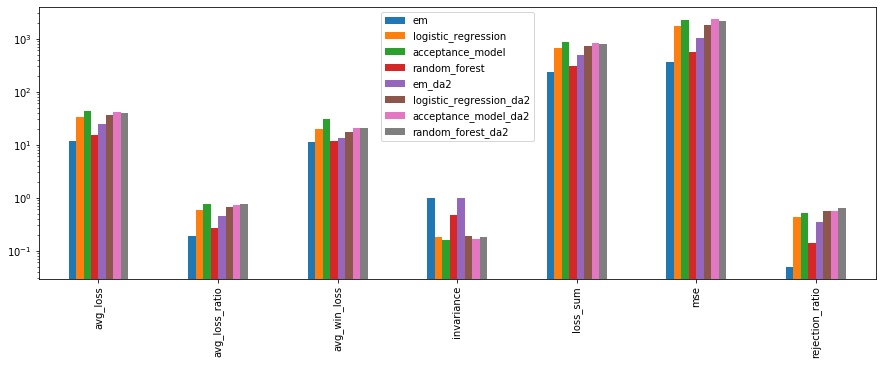

In [22]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**TOP MODELS**

In [23]:
from sklearn.svm import SVR
benchmark_models = {
    'em': EMModel(),
    'logistic_regression': LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'),
    'svc': SVC(gamma='auto'),
    'acceptance_model': AcceptanceModel(step=10, zero_one=True),
    'acceptance_model_svr': AcceptanceModel(SVR(gamma='auto', kernel='poly', degree=1), step=10, zero_one=True),
    
    # Classification
    #"random_forest": RandomForestClassifier(min_samples_leaf=5),#max_depth=3, random_state=0, n_estimators=10),
}

results = dict()

results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=None)

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
results_df = pd.DataFrame(results_mean).T
results_df.sort_values("avg_loss_ratio", inplace=True)
results_df

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y

,avg_loss,avg_loss_ratio,avg_win_loss,invariance,loss_sum,mse,rejection_ratio
em,11.60,0.188273,11.370175,1.000000,232.0,369.00,0.05
svc,11.60,0.188273,11.370175,1.000000,232.0,369.00,0.05
acceptance_model_svr,28.50,0.504101,21.414286,0.198161,570.0,1301.00,0.29
logistic_regression,33.05,0.583989,19.839744,0.182321,661.0,1738.25,0.44
acceptance_model,36.40,0.641924,30.640705,0.162545,728.0,1795.00,0.29


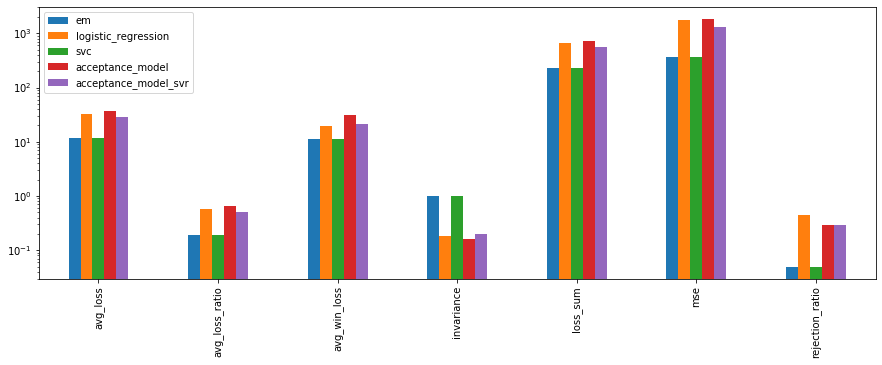

In [24]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

In [25]:
from sklearn.svm import SVR
benchmark_models = {
    'mlp': MLPClassifier(
        hidden_layer_sizes=(1024,), max_iter=1024, solver='sgd',
        learning_rate='adaptive',
        activation='relu',
    ),
    'log_reg': LogisticRegression(multi_class='auto', solver='lbfgs'),
}

results = dict()

results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=None)

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
results_df = pd.DataFrame(results_mean).T
results_df.sort_values("avg_loss_ratio", inplace=True)
results_df

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: Convergence

,avg_loss,avg_loss_ratio,avg_win_loss,invariance,loss_sum,mse,rejection_ratio
mlp,24.0,0.430891,12.928571,0.216054,480.0,1142.5,0.32
log_reg,31.9,0.571958,18.444444,0.189664,638.0,1636.5,0.43


In [26]:
from core.models.metrics import avg_gain_ratio
clf = ClusterExtModel(base_model="affinity")
xTrain, xTest, yTrain, yTest = train_test_split(x, y)
clf.fit(xTrain, yTrain)

# clf = EMModel()
xTrain, xTest, yTrain, yTest = train_test_split(x, y)
clf.fit(xTrain, yTrain)

yPred = clf.predict(xTrain)

print(np.unique(yPred))

print("acc: ", avg_gain_ratio(yTrain, yPred))
yPred = clf.predict(xTest)
print(np.unique(yPred))
print("val_acc: ", avg_gain_ratio(yTest, yPred))

[50.]
acc:  0.8199014922699133
[50.]
val_acc:  0.7872019793072424
